## Постановка задачи

Обучить нейронную сеть для решения задачи классификации цифр из датасета MNIST. Сеть должна состоять из входного слоя с 784 нейронами, скрытого слоя с $s$ нейронами и выходного слоя с 10 нейронами. Входной слой связан со скрытым с помощью полносвязного слоя, за которым следует функция активации ReLU. Скрытый слой связан с выходным с помощью полносвязного слоя и функции softmax.

Требуется добиться точности не менее 95% на тестовой выборке с контрольными параметрами:
- Размер пачки данных: от 8 до 64 изображений (в зависимости от доступного объема памяти);
- Скорость обучения: 0.1;
- Количество скрытых нейронов $s$: 300;
- Количество эпох: 20.

## Теоретические основы метода обратного распространения ошибки

Нейронная сеть является функцией, зависящей от входных данных и параметров (весов), которые подбираются в процессе обучения.  
Обучение сводится к минимизации функции потерь $L$, измеряющей расхождение между предсказанием модели и правильным ответом.

---

### Архитектура модели

В данной работе используется **двухслойная полносвязная нейронная сеть**:

$$
x \; \xrightarrow[\text{FC}]{W^{(x)},\,b^{(x)}} \; z_1 \; \xrightarrow[\text{ReLU}]{} \; a_1 \;
\xrightarrow[\text{FC}]{W^{(z)},\,b^{(z)}} \; z_2 \; \xrightarrow[\text{Softmax}]{} \; a_2
$$

- $x \in \mathbb{R}^{784}$ — входной вектор (изображение 28×28 пикселей, «выпрямленное» в вектор);  
- $z_1, a_1$ — линейная комбинация и активации скрытого слоя;  
- $z_2, a_2$ — линейная комбинация и вероятности классов на выходном слое.

Формулы прямого прохода (forward pass):

$$
z_1 = W^{(x)} x + b^{(x)}, \quad a_1 = \text{ReLU}(z_1)
$$

$$
z_2 = W^{(z)} a_1 + b^{(z)}, \quad a_2 = \text{Softmax}(z_2)
$$

где
$$
\text{ReLU}(t) = \max(0, t), \quad
\text{Softmax}(v_j) = \frac{e^{v_j}}{\sum_i e^{v_i}}
$$

---

### Функция потерь

Для многоклассовой классификации используется **кросс-энтропийная функция потерь**:

$$
L = -\frac{1}{N} \sum_{k=1}^{N} \sum_{j=1}^{10} y_j^{(k)} \ln a_{2j}^{(k)},
$$

где $y_j^{(k)}$ — корректная метка (в one-hot виде), $a_{2j}^{(k)}$ — предсказанная вероятность класса $j$.

---

### Обратное распространение ошибки (backpropagation)

Метод обратного распространения ошибки вычисляет градиенты функции потерь по весам всех слоёв.  
Процесс делится на **прямой** и **обратный** проходы.

#### 1. Градиенты выходного слоя

Локальный градиент ошибки (разность предсказания и правильного ответа):

$$
\delta^{(2)} = a_2 - y
$$

Градиенты по весам и смещениям:

$$
\frac{\partial L}{\partial W^{(z)}} = a_1^T \delta^{(2)}, \quad
\frac{\partial L}{\partial b^{(z)}} = \sum \delta^{(2)}
$$

#### 2. Градиенты скрытого слоя

Ошибка передаётся назад через веса и модифицируется производной активации ReLU:

$$
\delta^{(1)} = (\delta^{(2)} {W^{(z)}}^T) \odot \text{ReLU}'(z_1),
$$

$$
\frac{\partial L}{\partial W^{(x)}} = x^T \delta^{(1)}, \quad
\frac{\partial L}{\partial b^{(x)}} = \sum \delta^{(1)}
$$

где $\odot$ — поэлементное умножение.

---

### Обновление весов

Параметры обновляются с помощью **градиентного спуска**:

$$
W \leftarrow W - \eta \frac{\partial L}{\partial W}, \quad
b \leftarrow b - \eta \frac{\partial L}{\partial b},
$$

где $\eta$ — скорость обучения (*learning rate*).

---

### Итог

Таким образом, обучение нейронной сети представляет собой процесс итеративного уточнения весов на основе градиентов, вычисленных методом обратного распространения ошибки.  
Этот метод обеспечивает эффективное распространение информации об ошибке от выходного слоя к входным, позволяя сети "учиться" различать изображения цифр.


## Реализация

### Импорт библиотек и загрузка данных

In [1]:
%pip install idx2numpy

  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7903 sha256=a46680edca9e8fe7a2fd7d5033c968897769ce6b59600281dacf34c23e61bb36
  Stored in directory: /root/.cache/pip/wheels/f7/48/00/ae031c97d62f39e1c3c4daa00426c09a65eb29ae5753a189ee
Successfully built idx2numpy


In [2]:
# === Импорт необходимых библиотек ===
import numpy as np              # работа с массивами
import matplotlib.pyplot as plt # визуализация изображений
import idx2numpy                # чтение файлов формата .idx (в которых хранится MNIST)
import kagglehub                # библиотека для загрузки датасетов с Kaggle

# === Загрузка датасета MNIST ===
path = kagglehub.dataset_download("hojjatk/mnist-dataset")
print("Путь к датасету MNIST:", path)

# === Чтение изображений и меток ===
x_train_raw = idx2numpy.convert_from_file(f"{path}/train-images.idx3-ubyte")
y_train = idx2numpy.convert_from_file(f"{path}/train-labels.idx1-ubyte")

x_test_raw  = idx2numpy.convert_from_file(f"{path}/t10k-images.idx3-ubyte")
y_test  = idx2numpy.convert_from_file(f"{path}/t10k-labels.idx1-ubyte")

# === Проверка формы массивов ===
print("Форма x_train:", x_train_raw.shape)
print("Форма y_train:", y_train.shape)
print("Форма x_test:", x_test_raw.shape)
print("Форма y_test:", y_test.shape)


Using Colab cache for faster access to the 'mnist-dataset' dataset.
Путь к датасету MNIST: /kaggle/input/mnist-dataset
Форма x_train: (60000, 28, 28)
Форма y_train: (60000,)
Форма x_test: (10000, 28, 28)
Форма y_test: (10000,)


### Визуализация нескольких обучающих изображений

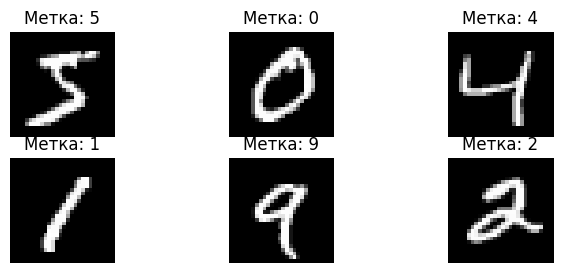

In [3]:
plt.figure(figsize=(8, 3))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(x_train_raw[i], cmap='gray')
    plt.title(f"Метка: {y_train[i]}")
    plt.axis('off')
plt.show()


### Обработка данных


*   Выпрямление изображений 28x28 в вектор длиной 784
*   Нормализизация данных. Значения пикселей в MNIST — от 0 до 255. Делим на 255, чтобы привести их к диапазону [0, 1]




In [4]:
# === "Выпрямим" каждое изображение  ===
x_train = x_train_raw.reshape((x_train_raw.shape[0], -1))
x_test  = x_test_raw.reshape((x_test_raw.shape[0], -1))

# === Нормализуем данные ===
x_train = x_train / 255.0
x_test  = x_test / 255.0

print("Размерность после преобразования:")
print("x_train:", x_train.shape)
print("x_test:", x_test.shape)

Размерность после преобразования:
x_train: (60000, 784)
x_test: (10000, 784)


### Класс нейронной сети

In [5]:
import numpy as np
import time

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, seed=42):
        """
        Двухслойная полносвязная сеть:
          input_size  — 784 (28x28)
          hidden_size — например, 300
          output_size  — 10 (цифры 0..9)
        """
        np.random.seed(seed)
        # Инициализация весов (He-подобная инициализация для ReLU)
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
        self.b2 = np.zeros((1, output_size))

    # -------------------
    #  Активации и loss
    # -------------------
    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

    def softmax(self, x):
        """
        Softmax по строкам: вход shape (m, 10) -> выход (m, 10)
        Сдвиг для численной стабильности.
        """
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def cross_entropy(self, y_pred, y_true):
        """
        Кросс-энтропия для one-hot y_true.
        y_pred: (m, 10), y_true: (m, 10)
        Возвращает среднюю потерю по батчу.
        """
        eps = 1e-12
        m = y_true.shape[0]
        clipped = np.clip(y_pred, eps, 1.0 - eps)
        loss = -np.sum(y_true * np.log(clipped)) / m
        return loss

    # -------------------
    #    Forward pass
    # -------------------
    def forward(self, X):
        """
        Прямой проход. Сохраняет промежуточные значения для backward.
        X: (m, 784)
        Возвращает y_pred (m, 10)
        """
        self.X = X                       # вход (m, input_size)
        self.z1 = X.dot(self.W1) + self.b1   # линейная часть скрытого слоя (m, s)  (здесь q)
        self.a1 = self.relu(self.z1)         # активация скрытого слоя (m, s)      (здесь z)
        self.z2 = self.a1.dot(self.W2) + self.b2  # линейная часть выходного слоя (m, 10) (v)
        self.a2 = self.softmax(self.z2)          # выход — вероятности (m, 10)         (u)
        return self.a2

    # -------------------
    #   Backpropagation
    # -------------------
    def backward(self, y_true, learning_rate=0.1):
        """
        Вычисление градиентов и обновление весов (SGD).
        y_true: (m, 10) — one-hot
        """
        m = y_true.shape[0]

        # 1) Градиент по z2 (v): для softmax + cross-entropy упрощается до (a2 - y) / m
        dz2 = (self.a2 - y_true) / m                        # (m, 10)

        # 2) Градиенты для W2, b2
        dW2 = self.a1.T.dot(dz2)                            # (s, 10)
        db2 = np.sum(dz2, axis=0, keepdims=True)            # (1, 10)

        # 3) Градиент по a1 (то, что "приходит" в скрытый слой)
        da1 = dz2.dot(self.W2.T)                            # (m, s)

        # 4) Учитываем ReLU: d z1 = da1 * ReLU'(z1)
        dz1 = da1 * self.relu_derivative(self.z1)           # (m, s)

        # 5) Градиенты для W1, b1
        dW1 = self.X.T.dot(dz1)                             # (input_size, s)
        db1 = np.sum(dz1, axis=0, keepdims=True)            # (1, s)

        # 6) Обновление параметров (SGD шаг)
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2

    # -------------------
    #   Метрики / утилиты
    # -------------------
    def predict(self, X):
        """Возвращает предсказания меток (целые 0..9)"""
        probs = self.forward(X)
        return np.argmax(probs, axis=1)

    def accuracy(self, X, y_true_onehot):
        """Точность: сравниваем argmax-ы"""
        y_pred = self.forward(X)
        return np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_true_onehot, axis=1))

    # -------------------
    #     Train loop
    # -------------------
    def train(self, X_train, y_train_oh, X_test=None, y_test_oh=None,
              epochs=20, batch_size=32, learning_rate=0.1, verbose=True):
        n = X_train.shape[0]
        history = {"loss": [], "train_acc": [], "test_acc": []}

        for epoch in range(1, epochs + 1):
            t0 = time.time()
            # Перемешивание
            idx = np.random.permutation(n)
            Xs = X_train[idx]
            ys = y_train_oh[idx]

            epoch_loss = 0.0
            for i in range(0, n, batch_size):
                Xb = Xs[i:i+batch_size]
                yb = ys[i:i+batch_size]

                y_pred = self.forward(Xb)
                batch_loss = self.cross_entropy(y_pred, yb)
                epoch_loss += batch_loss * Xb.shape[0]  # аккумулируем суммарную потерю

                self.backward(yb, learning_rate=learning_rate)

            # усреднённая потеря по эпохе
            epoch_loss /= n
            train_acc = self.accuracy(X_train, y_train_oh)
            history["loss"].append(epoch_loss)
            history["train_acc"].append(train_acc)

            if X_test is not None and y_test_oh is not None:
                test_acc = self.accuracy(X_test, y_test_oh)
                history["test_acc"].append(test_acc)
            else:
                test_acc = None

            t1 = time.time()
            if verbose:
                print(f"Эпоха {epoch}/{epochs} | loss: {epoch_loss:.4f} | "
                      f"train_acc: {train_acc*100:.2f}% | "
                      f"test_acc: {None if test_acc is None else f'{test_acc*100:.2f}%'} | "
                      f"time: {t1-t0:.2f}s")

        return history

### Обучение модели

In [6]:
# Преобразуем метки в one-hot
def to_one_hot(y, num_classes=10):
    y_onehot = np.zeros((y.shape[0], num_classes))
    y_onehot[np.arange(y.shape[0]), y] = 1
    return y_onehot

y_train_oh = to_one_hot(y_train)
y_test_oh = to_one_hot(y_test)

In [7]:
nn = NeuralNetwork(784, 300, 10)
history = nn.train(x_train, y_train_oh, x_test, y_test_oh, epochs=20, batch_size=32, learning_rate=0.1)

Эпоха 1/20 | loss: 0.2870 | train_acc: 95.46% | test_acc: 95.44% | time: 20.50s
Эпоха 2/20 | loss: 0.1324 | train_acc: 97.19% | test_acc: 96.77% | time: 9.47s
Эпоха 3/20 | loss: 0.0941 | train_acc: 97.97% | test_acc: 97.13% | time: 6.86s
Эпоха 4/20 | loss: 0.0719 | train_acc: 98.58% | test_acc: 97.64% | time: 9.08s
Эпоха 5/20 | loss: 0.0577 | train_acc: 98.59% | test_acc: 97.40% | time: 9.68s
Эпоха 6/20 | loss: 0.0476 | train_acc: 99.03% | test_acc: 97.85% | time: 7.01s
Эпоха 7/20 | loss: 0.0399 | train_acc: 99.22% | test_acc: 97.84% | time: 9.97s
Эпоха 8/20 | loss: 0.0330 | train_acc: 99.43% | test_acc: 97.94% | time: 8.37s
Эпоха 9/20 | loss: 0.0279 | train_acc: 99.54% | test_acc: 97.99% | time: 7.44s
Эпоха 10/20 | loss: 0.0235 | train_acc: 99.63% | test_acc: 98.03% | time: 10.34s
Эпоха 11/20 | loss: 0.0194 | train_acc: 99.72% | test_acc: 97.99% | time: 7.43s
Эпоха 12/20 | loss: 0.0169 | train_acc: 99.75% | test_acc: 97.93% | time: 9.16s
Эпоха 13/20 | loss: 0.0141 | train_acc: 99.88% 

### Тестирование модели

In [9]:
print("\n=== Финальная оценка модели ===")

# Прямой проход по тестовой выборке
y_test_pred = nn.forward(x_test)

# Преобразуем вероятности в метки классов
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
y_test_true_labels = np.argmax(y_test_oh, axis=1)

# Считаем потери и точность
final_loss = nn.cross_entropy(y_test_pred, y_test_oh)
final_accuracy = np.mean(y_test_pred_labels == y_test_true_labels)

print(f"Test loss: {final_loss:.4f}")
print(f"Test accuracy: {final_accuracy*100:.2f}%")


=== Финальная оценка модели ===
Test loss: 0.0614
Test accuracy: 98.18%


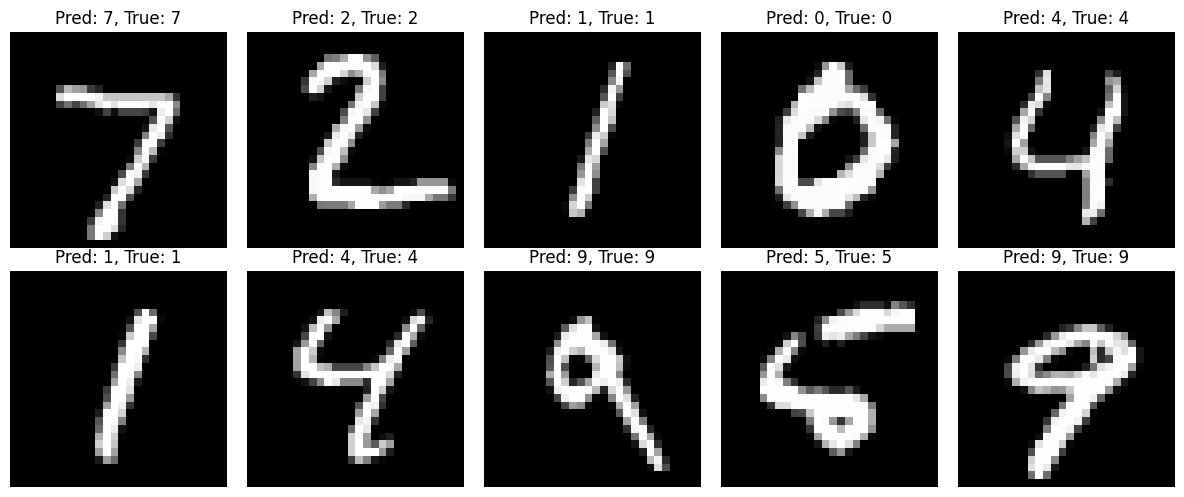

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"Pred: {y_test_pred_labels[i]}, True: {y_test_true_labels[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()